# 신경망 모델 훈련 도구
- 머신러닝 알고리즘은 사이킷런에서 제공하는 머신러닝 알고리즘을 좋은 성능을 내기 위해 매개변수 조정과 훈련하는 과정을 반복
- 인공 신경망(딥러닝)은 모델의 구조를 직접 만드는 개념
- 케라스 API를 사용하여 모델을 훈련하는데 필요한 도구 확인
    - 손실곡선
    - 드랍아웃
    - 콜백
    - 조기종료

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# 손실곡선
- fit()메서드로 모델 훈련 시 훈련 과정이 상세하게 출력됨(에포크 횟수, 손실, 정확도 등)
- fit()메서드가 반환하는 History객체는 훈련과정에서 계산한 지표(손실과 정확도 값이 저장되어 있음)
- History객체가 가진 값을 이용하여 그래프 그리기

#### 데이터셋 준비 및 데이터 나누기

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = \
    keras.datasets.fashion_mnist.load_data()

X_train_scaled = X_train / 255.0

X_train_scaled, X_test_val_scaled, y_train, y_test_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42)

#### 모델을 정의하는 코드를 함수로 정의(편의상)

In [43]:
def model_fn(a_layer=None): # a_layer 하나의 매개변수를 받는다. 기본값은 None
    model = keras.Sequential() # Sequential 모델은 각 레이어가 순차적으로 쌓여서 신경망을 구성
    model.add(keras.layers.Input(shape=(28, 28))) #모델의 첫번째 레이어로 입력 레이어를 추가합니다. 28 * 28 크기의 이미지를 입력받음

    # 2차원 이미지 데이터를 1차원으로 펼쳐서 입력으로 받는다.
    model.add(keras.layers.Flatten())
    # 100개의 뉴런으로 이루어진 Dense 레이어를 추가합니다.
    # 입력 데이터를 받아서 100개의 은닉 뉴런을 가진 완전 연결층을 구성하고, 함수는 ReLU 사용
    model.add(keras.layers.Dense(100, activation='relu'))

    # a_layer가 주어진다면, 외부에서 추가한 레이어를 모델에 넣을 수 있도록 함.
    if a_layer:
        model.add(a_layer)
    # 10개의 뉴런으로 이루어진 Dense 레이어를 추가합니다
    # 모델의 최종 출력을 담당하며, 클래스에 대한 확률을 출력하기 위해 소프트 맥스활성화 함수를 사용
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

#### 함수를 호출하여 모델 생성 및 구조 확인
- 함수를 이용했을 뿐 앞에서 만들었던 신경망 모델과 동일한 모델이 생성됨

In [44]:
model = model_fn()

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

#### 모델 훈련(fit) 후 훈련 결과객체를 history변수로 참조
- verbose: 훈련 과정 출력 여부 설정  
    0: 아무것도 출력하지 않음  
    1: 기본값으로 에포크마다 진행바 및 손실등 지정한 지표 출력  
    2: 진행바를 제외하고 출력  

In [5]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=5, verbose=0)

#### History객체가 가진 hisotory딕셔너리의 키값 확인

In [6]:
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


##### 결과
- 훈련과정에서 계산한 지표(여기서는 손실과 정확도)가 들어있음
- 이는 compile()시 metrics매개변수로 accuracy를 추가했기 때문에 포함되어짐
- 에포크마다 계산한 값이 순서대로 나열된 단순 리스트

In [7]:
history.history['loss'], history.history['accuracy']

([0.5311373472213745,
  0.3905622959136963,
  0.35328054428100586,
  0.329425573348999,
  0.31286558508872986],
 [0.8112499713897705,
  0.8586458563804626,
  0.8727708458900452,
  0.8809166550636292,
  0.8888333439826965])

#### 맷플롯립을 이용하여 손실 그래프 그리기

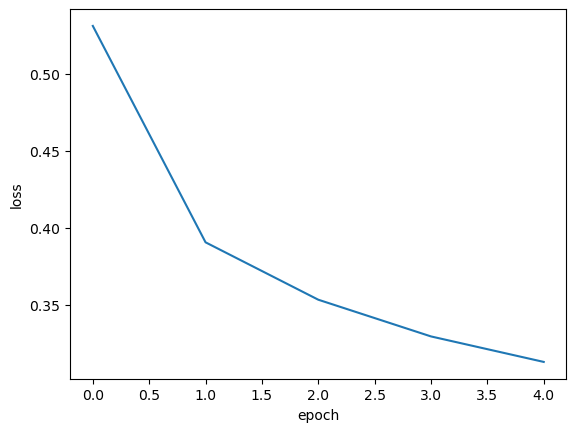

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### 맷플롯립을 이용하여 정확도 그래프 그리기

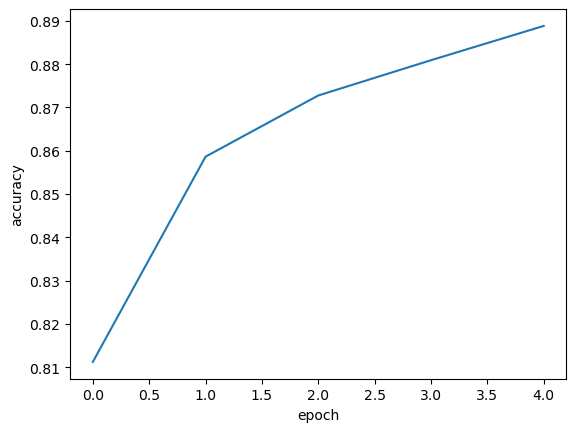

In [9]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### 에포크 횟수를 20으로 모델을 훈련하고 손실 그래프 그리기

In [10]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=20, verbose=0)

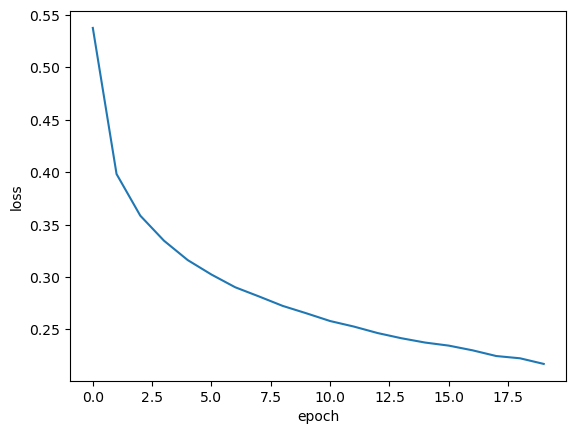

In [11]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

##### 결과
- 손실이 감소하는 것이 확인됨
- 더 나은 모델이란 에포크 횟수를 증가시켜 손실이 감소되는 것만으로 판단할 수 없음(과대적합 고려)

# 검증 손실
- 에포크에 따른 과대적합과 과소적합을 파악하기 위해 훈련세트 점수에 검증세트 점수까지 모두 필요함
- 훈련세트의 손실만 그리는 것은 모델이 더 나은지를 확인하는데 의미가 없음
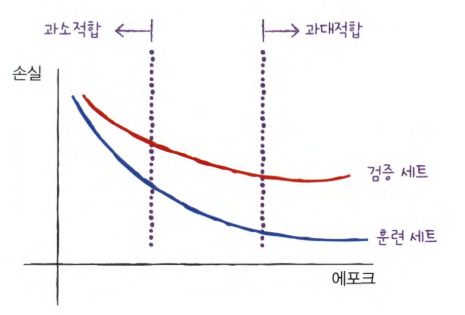
- 에포크마다 검증 손실을 계산하기 위해 fit()호출 시 validation_data로 검증에 사용할 데이터를 전달

In [12]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=20, verbose=0, 
                    validation_data=(X_test_val_scaled, y_test_val))

#### history.history딕셔너리에 들어있는 키 값 확인
- 검증세트의 손실: val_loss
- 검증세트의 정확도: val_accuracy

In [13]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


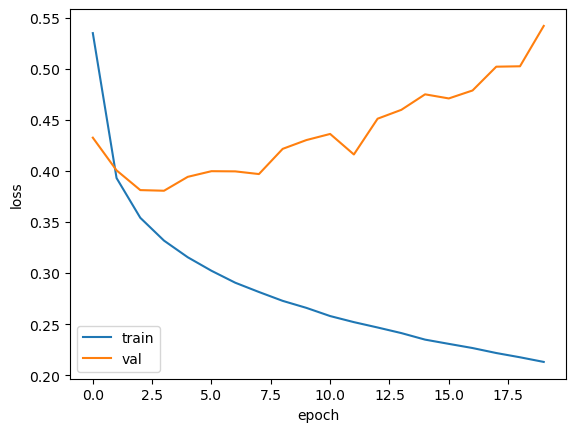

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 초기에는 손실이 감소하다가 다섯 번째 에포크에서 다시 상승
- 훈련 손실은 반복할수록 감소하므로 과대적합으로 진행됨
- 검증 손실이 증가되는 시점을 최대한 뒤로 미루면 검증세트에 대한 손실이 적고 정확도가 증가할 것으로 보임

#### 옵티마이저를 적용하여 모델을 개선
- RMSprop은 많은 문제에서 잘 동작
- Adam은 적응적 학습률을 사용하므로 에포크가 진행되면서 학습률 크기 조정이 가능하여 좋은 선택이 될 수 있음

In [17]:
# Adam 적용
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', # adam 모델 적용
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=20, verbose=0, 
                    validation_data=(X_test_val_scaled, y_test_val))

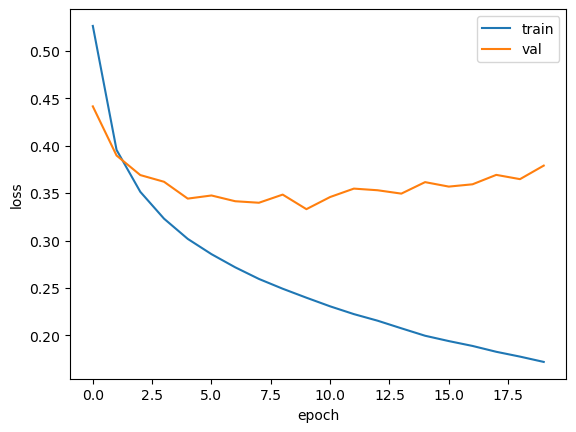

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 옵티마이저 적용 후 과대적합이 많이 줄어들었음
- 검증 손실 그래프가 불안하지만 10번째 에포크까지는 전반적으로 감소하는 추세로 보임
- Adam 옵티마이저의 학습률을 조정하여 다시 시도해볼 수도 있음
- 다른 옵티마이저로 테스트하여 잘 맞은 것을 선택할 수도 있음

# 드랍아웃(dropout)
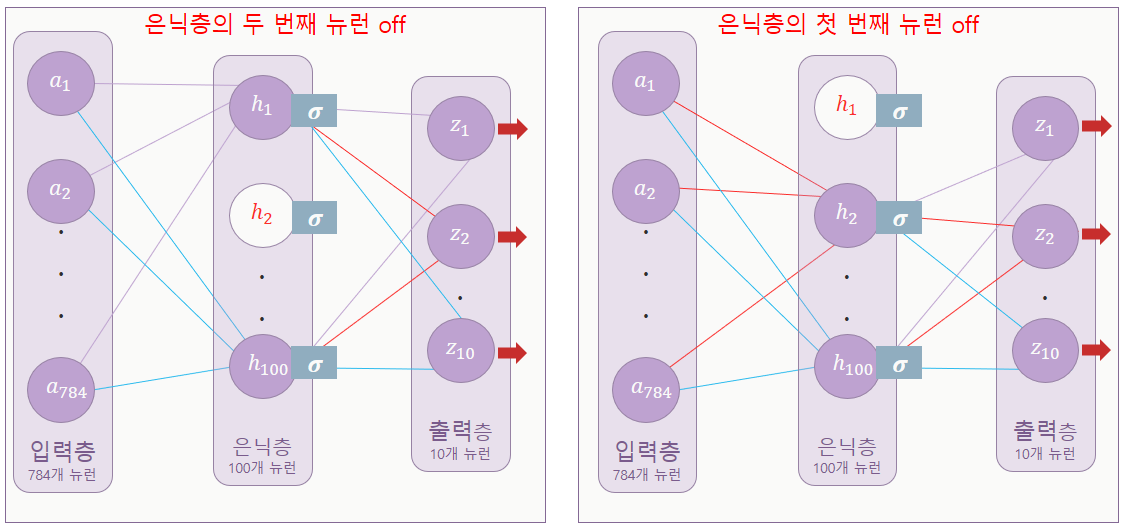
- 인공신경망에서 사용하는 대표적인 과대적합에 대한 규제 방식
- 옵티마이저로 조정하는 것보다 더 직접적인 규제를 가하는 방식
- 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 off(출력을 0으로)하여 과대적합을 방지
- 얼마나 많은 뉴런을 드랍아웃할 것인지는 직접 지정해야 함

## 드랍아웃으로 과대적합을 막는 원리
- 이전 층의 일부 뉴런이 랜덤하게 off되면 특정 뉴런에 과대하게 의존하는 것을 줄임
- 모든 입력에 대해 주의하여 일부 뉴런의 출력이 없을 수 있다는 것을 감안하면 보다 안정적인 예측을 생성할 수 있음
- 위 그림을 보면 2개의 신경망을 앙상블하는 것과 같은 개념으로 해석하기도 함
- 케라스에서는 keras.layers.Dropout 클래스로 제공되며 특정 층의 뒤에 위치하여 출력을 랜덤하게 0으로 만듦
- 드랍아웃이 층처럼 사용되나 훈련되는 모델 파라미터는 없음

#### model_fn() 함수를 이용하여 드랍아웃을 추가한 모델 생성
- 30% 정도를 드랍아웃하도록 생성

In [20]:
model = model_fn(keras.layers.Dropout(0.3))

model.summary()
# 일부 뉴런의 출력을 0 만들뿐
# 출력 배열의 크기를 변경 x

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

##### 해석
- 은닉층 뒤에 추가된 드랍아웃 확인
- 드랍아웃은 모델 파라미터가 없음
- 일부 뉴런의 출력을 0으로 만들뿐 출력 배열의 크기를 변경하지 않음(필터 같은 개념)
- 훈련이 끝난 후 평가 또는 예측을 할 때는 드랍아웃 적용을 하지 않아야 함
- 텐서플로우와 케라스는 모델의 평가와 예측을 사용할 때 자동으로 드랍아웃을 적용하지 않음

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=20, verbose=0, 
                    validation_data=(X_test_val_scaled, y_test_val))

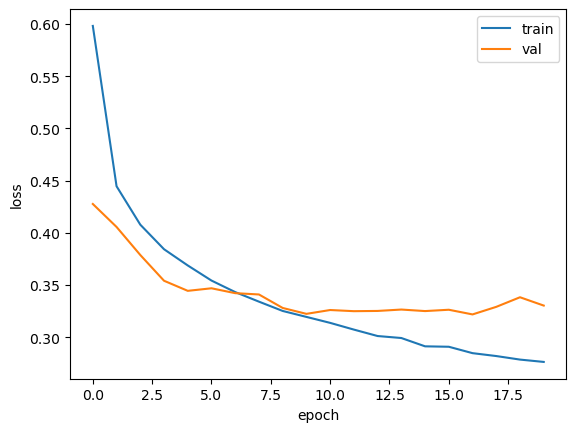

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 과대적합이 확실하게 줄어들었음을 확인
- 가장 나은 모델을 만들기 위해서 에포크 횟수를 10 정도로 조절하여 다시 훈련해야 함을 알 수 있음

# 모델 저장과 복원
- 훈련한 모델을 나중에 사용하기 위해 저장이 필요
- 케라스 모델은 save_weights() 메서드를 이용하여 훈련된 모델 저장가능
- 기본적으로 텐서플로우의 체크포인트 포멧으로 저장됨
    - 여기서는 HDF5포멧으로 저장(.h5 확장자 지정)

#### 에포크 횟수를 10으로 모델 훈련

In [23]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=10, verbose=0, 
                    validation_data=(X_test_val_scaled, y_test_val))

#### 훈련된 모델 저장하기
- save_weights()는 훈련된 모델 파라미터를 저장
- 저장된 모델은 load_weights()로 불러올 수 있음(단 저장될 때의 구조와 동일한 신경망 모델을 준비해야 함)
- save()는 모델 구조와 모델 파라미터를 함께 저장
    - 기본 저장 포멧은 SavedModel포멧
    - 확장자를 h5로 지정시 HDF5 포멧으로 저장함

In [24]:
# 모델 파라미터 저장
model.save_weights('model.weights.h5')

In [29]:
# 모델 구조와 모델 파라미터를 함께 저장
model.save('model-whole.h5')

In [28]:
# 저장된 파일 확인
!find . -name "*.h5"

./model.weights.h5
./model-whole.h5


- model.weights.h5에 저장된 파일 내용
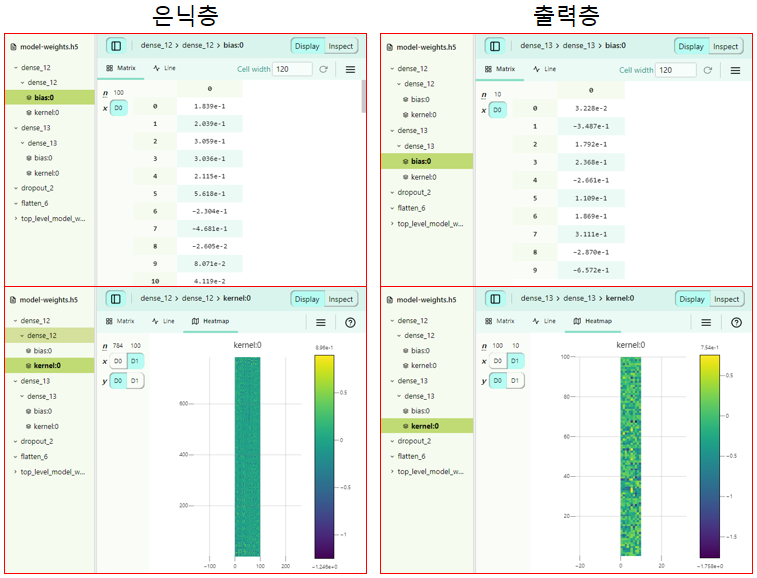
- model-whole.h5에 저장된 파일 내용(모델 파라미터 관련 옵티마이저 적용 내용까지 보임)
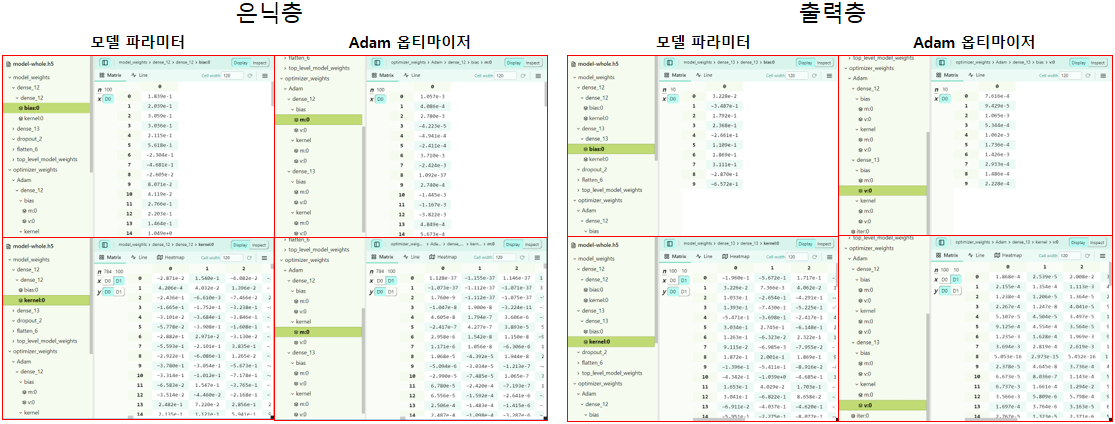

#### 모델 파라미터만 있는 파일을 불러와 모델 생성하기
1) 훈련을 하지 않은 새로운 신경망 모델을 생성  
2) model.weights.h5 파일을 로딩하여 1)에서 생성한 모델에 적용
- load_weights() 사용 시 save_weights()로 저장할 때의 모델과 정확히 같은 구조를 가져야 함

In [30]:
model = model_fn(keras.layers.Dropout(0.3))

model.load_weights('model.weights.h5')

#### 생성한 모델로 검증 정확도 확인
- predict()는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률을 반환(현재 다중 분류이므로)
- 이진 분류 문제일 경우는 양성 클래스에 대한 확률 하나만 반환
- evaluate()를 사용하여 정확도를 출력하고자 할 경우 손실 계산을 위해 반드시 compile() 실행이 필요함
- 이 예시에서는 새로운 데이터에 대한 정확도만 계산

In [31]:
import numpy as np

val_labels = np.argmax(model.predict(X_test_val_scaled), axis=-1) # 여기서는 axis=1과 같음
print(np.mean(val_labels == y_test_val))

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
0.8791666666666667


##### 해석
- predict() 결과에서 가장 큰 값을 고르기 위해 argmax()를 적용
- argmax()는 배열에서 가장 큰 값의 인덱스를 반환
- axis=-1은 배열의 마지막 차원을 축으로하여 최댓값을 찾음(검증세트는 2차원이므로 마지막 차원은 1차원을 의미) axis=1과 같음
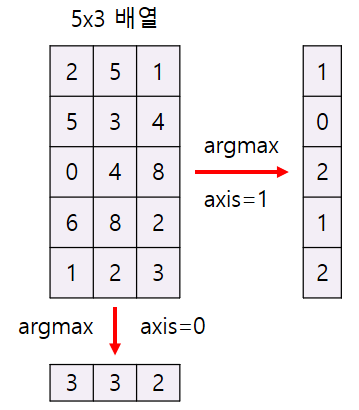
- argmax()로 선택한 인덱스와 va_target을 비교하여 각 위치의 값이 같으면 1 다르면 0
- 비교 결과를 평균하면 정확도가 됨

#### 모델 파라미터와 신경망 구조가 함께 저장된 파일을 불러와 모델 생성하기
- load_model() 사용  
- 모델 파라미터 및 모델 구조와 옵티마이저 상태까지 모두 복원하기 때문에 evaluate()호출 가능  

1) model-whole.h5 파일을 로딩하여 바로 모델 생성

In [32]:
model = keras.models.load_model('model-whole.h5')

model.evaluate(X_test_val_scaled, y_test_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.8795 - loss: 0.3340


[0.33806440234184265, 0.8791666626930237]

# 콜백(callback)
- 앞에서 20번의 에포크 동안 모델을 훈련하여 검증 점수(정확도)가 상승하는 지점을 확인할 수 있었음
- 과대적합된 모델이 생성되지 않도록 해당 지점에 해당하는 에포크 횟수로 다시 모델을 훈련해야 함
- 콜백은 훈련 과정 중간에 어떤 작업을 수행할 수 있도록 함
- keras.callbacks 패키지 하위에 정의된 클래스들을 활용
- fit()호출 시 callbacks=매개변수에 리스트로 전달하여 콜백 적용
- ModelCheckpoint콜백은 기본적으로 에포크마다 모델을 저장
- save_best_only=True를 지정하여 가장 낮은 검증 손실을 만드는(베스트) 모델을 저장할 수 있음

In [35]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.keras', 
                                                save_best_only=True)

model.fit(X_train_scaled, y_train, epochs=20, verbose=0, 
          validation_data=(X_test_val_scaled, y_test_val),
          callbacks=[checkpoint_cb])

##### 설명
- model_fn()을 호출하여 모델을 생성하고 compile() 호출(이전과 동일한 작업)
- ModelCheckpoint 클래스로 checkpoint_cb 객체를 생성하여 fit()에 callbacks옵션으로 전달

In [36]:
# 저장된 모델정보를 불러와 다시 예측 수행
model = keras.models.load_model('best-model.keras')

model.evaluate(X_test_val_scaled, y_test_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - accuracy: 0.8879 - loss: 0.3218


[0.3217014968395233, 0.8869166374206543]

##### 설명
- ModelCheckpoint콜백이 가장 낮은 검증 손실을 가지는 모델을 자동으로 저장함
- 에포크 횟수는 20번으로 줄어들지는 않음
- 검증 점수(정확도)가 높아지기 시작하면 그 후에는 과대적합이 더 커지므로 훈련을 계속할 이유가 없음
- 과대적합이 시작되기 전 훈련을 미리 중지할 수 있음(조기종료)

### 조기종료(early stopping)
- 에포크 횟수를 제한하고 모델의 과대적합을 방지
- 케라스는 EarlyStopping 콜백을 제공함
    - patience 매개변수를 이용하여 검증 점수가 향상되지 않아도 계속 진행시킬 에포크 횟수를 지정
        - patience=2 로 설정하면 2번 연속 검증 점수(정확도) 향상이 없는지 확인
        - 과적합 발생 전 훈련손실과 검증손실 모두 감소
        - 과적합이 발생하면 훈련손실은 감소, 검증 손실은 증가(이 시점을 보고 에포크 종료를 판단)
    - restore_best_weights=True 지정 시 가장 낮은 검증 손실을 보였던 모델 파라미터로 모델 상태를 되돌림

- EarlyStopping콜백과 ModelCheckpoint콜백을 같이 설정하면 두 가지 동작을 모두 적용할 수 있음
    - 가장 낮은 검증 손실(베스트)의 모델을 파일에 저장
    - 검증 손실이 다시 상승할 때 훈련 중지

In [37]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# 검증점수가 낮은 모델을 저장하는 콜백
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.keras', 
                                                save_best_only=True)
# 조기종료 콜백
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

# 총 에포크 수 20으로 지정
history = model.fit(X_train_scaled, y_train, epochs=20, verbose=0, 
                    validation_data=(X_test_val_scaled, y_test_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [39]:
# 몇 번째 에포크에서 중지되었는지 확인
early_stopping_cb.stopped_epoch

12

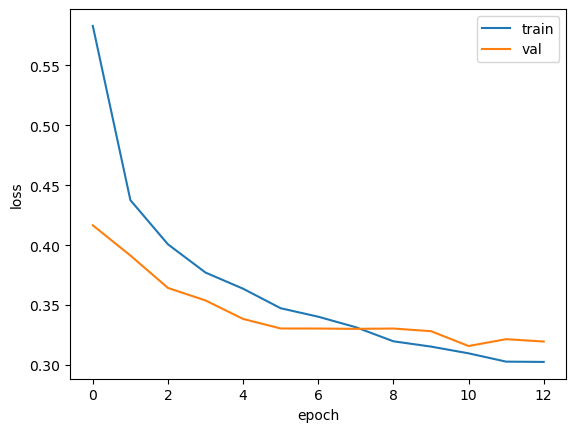

In [40]:
# 훈련 손실과 검증 손실 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 10번째 에포크에서 가장 낮은 검증 손실이었으므로 모델을 저장하고
- 12번째 에포크까지 검증 손실이 낮아지지 않아 훈련을 조기 종료함을 확인할 수 있음(patience=2)
- fit()호출 시 에포크 횟수가 많아도 콜백 조건에 맞으면 훈련이 종료되어 자원을 효율적으로 사용 가능

In [41]:
# 조기종료로 얻은 모델을 사용하여 검증세트에 대한 성능 확인
model.evaluate(X_test_val_scaled, y_test_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step - accuracy: 0.8860 - loss: 0.3147


[0.31587138772010803, 0.8847500085830688]